<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W3/ungraded_labs/C3_W3_Lab_2_multiple_layer_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Multiple LSTMs

In this lab, you will look at how to build a model with multiple LSTM layers. Since you know the preceding steps already (e.g. downloading datasets, preparing the data, etc.), we won't expound on it anymore so you can just focus on the model building code.

## Download and Prepare the Dataset

In [1]:
import tensorflow_datasets as tfds

# Download the subword encoded pretokenized dataset
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

# Get the tokenizer
tokenizer = info.features['text'].encoder

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteWP2Z26/imdb_reviews-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteWP2Z26/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteWP2Z26/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


Like the previous lab, we increased the `BATCH_SIZE` here to make the training faster. If you are doing this on your local machine and have a powerful processor, feel free to use the value used in the lecture (i.e. 64) to get the same results as Laurence.

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

# Get the train and test splits
train_data, test_data = dataset['train'], dataset['test'],

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

In [6]:
print(len(train_dataset))
print(len(test_dataset))

98
98


## Build and Compile the Model

You can build multiple layer LSTM models by simply appending another `LSTM` layer in your `Sequential` model and enabling the `return_sequences` flag to `True`. This is because an `LSTM` layer expects a sequence input so if the previous layer is also an LSTM, then it should output a sequence as well. See the code cell below that demonstrates this flag in action. You'll notice that the output dimension is in 3 dimensions `(batch_size, timesteps, features)` when when `return_sequences` is True.

In [9]:
import tensorflow as tf
import numpy as np

# Hyperparameters
batch_size = 1
timesteps = 20
features = 16
lstm_dim = 8

print(f'batch_size: {batch_size}')
print(f'timesteps (sequence length): {timesteps}')
print(f'features (embedding size): {features}')
print(f'lstm output units: {lstm_dim}')

# Define array input with random values
random_input = np.random.rand(batch_size,timesteps,features)
#print(f'data of input array: {random_input}')
print(f'shape of input array: {random_input.shape}')

# Define LSTM that returns a single output
lstm = tf.keras.layers.LSTM(lstm_dim)
result = lstm(random_input)
print(f'shape of lstm output(return_sequences=False): {result.shape}')

# Define LSTM that returns a sequence
lstm_rs = tf.keras.layers.LSTM(lstm_dim, return_sequences=True)
result = lstm_rs(random_input)
print(f'shape of lstm output(return_sequences=True): {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 16
lstm output units: 8
shape of input array: (1, 20, 16)
shape of lstm output(return_sequences=False): (1, 8)
shape of lstm output(return_sequences=True): (1, 20, 8)


The shape of the input array (1, 20, 16) means that it is a three-dimensional array, where the first dimension has a size of 1, the second dimension has a size of 20, and the third dimension has a size of 16.

In other words, the array contains 1 block or sample, where each block or sample has 20 rows and 16 columns of values.

The next cell implements the stacked LSTM architecture.

In [15]:
import tensorflow as tf

# Hyperparameters
embedding_dim = 64
lstm1_dim = 64
lstm2_dim = 32
lstm3_dim = 16
dense_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm3_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          523840    
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 64)         41216     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, None, 64)         24832     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 32)               10368     
 nal)                                                 

In [16]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the Model

The additional LSTM layer will lengthen the training time compared to the previous lab. Given the default parameters we set, it will take around 2 minutes per epoch with the Colab GPU enabled. 

In [17]:
NUM_EPOCHS = 10

# Train the model
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
98/98 [==============================] - 92s 797ms/step - loss: 0.5965 - accuracy: 0.6655 - val_loss: 0.4896 - val_accuracy: 0.7808
Epoch 2/10
98/98 [==============================] - 72s 731ms/step - loss: 0.3913 - accuracy: 0.8392 - val_loss: 0.4176 - val_accuracy: 0.8133
Epoch 3/10
98/98 [==============================] - 70s 713ms/step - loss: 0.3300 - accuracy: 0.8681 - val_loss: 0.4873 - val_accuracy: 0.8017
Epoch 4/10
98/98 [==============================] - 68s 694ms/step - loss: 0.3012 - accuracy: 0.8808 - val_loss: 0.4651 - val_accuracy: 0.7950
Epoch 5/10
98/98 [==============================] - 69s 700ms/step - loss: 0.2397 - accuracy: 0.9097 - val_loss: 0.4408 - val_accuracy: 0.8206
Epoch 6/10
98/98 [==============================] - 67s 682ms/step - loss: 0.1792 - accuracy: 0.9369 - val_loss: 0.4653 - val_accuracy: 0.8188
Epoch 7/10
98/98 [==============================] - 66s 675ms/step - loss: 0.1280 - accuracy: 0.9605 - val_loss: 0.5412 - val_accuracy: 0.8178

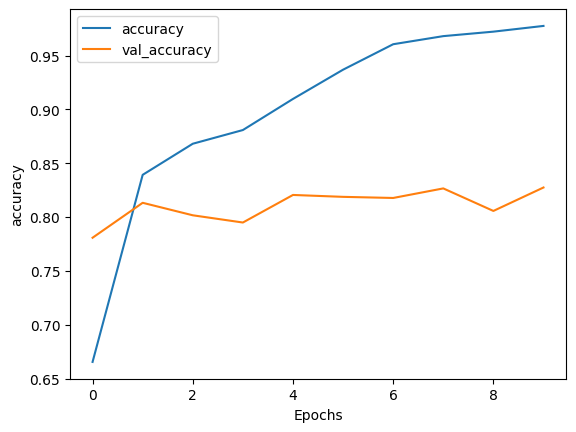

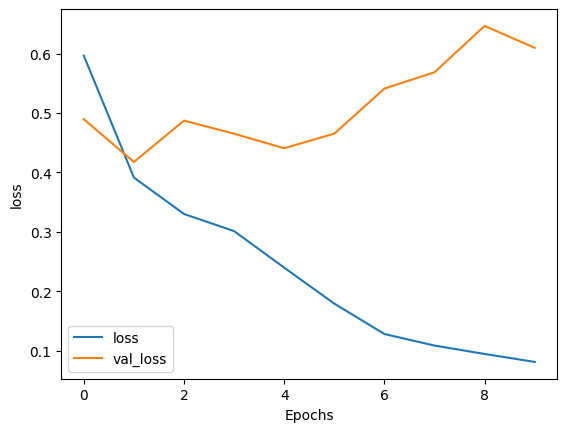

In [18]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Wrap Up

This lab showed how you can build deep networks by stacking LSTM layers. In the next labs, you will continue exploring other architectures you can use to implement your sentiment classification model.